In [1]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

print(tf.__version__)

2.7.0-dev20210806


In [2]:
# example data
words = ['good', 'bad', 'worse', 'so good']
y_data = [1, 0, 0, 1] # 긍정(1), 부정(0)

# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx: char for idx, char in enumerate(char_set)}
char2idx = {char: idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [3]:
# converting sequence of token to sequence of indices
x_data = list(map(lambda word: [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word: len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [5]:
# padding the sequence of indices
max_sequence = 10
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post', truncating='post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


In [7]:
# creating simple rnn for "many to one" classification
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_size))
model.add(layers.Dense(units=num_classes))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [13]:
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
                        y_true=y, y_pred=model(x), from_logits=True))

In [14]:
# creating an optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

In [15]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:.3f}'.format(epoch+1, avg_tr_loss.numpy()))

epoch:   5, tr_loss: 0.080
epoch:  10, tr_loss: 0.009
epoch:  15, tr_loss: 0.004
epoch:  20, tr_loss: 0.003
epoch:  25, tr_loss: 0.002
epoch:  30, tr_loss: 0.002


In [17]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc: {:.2%}'.format(np.mean(yhat == y_data)))

acc: 100.00%


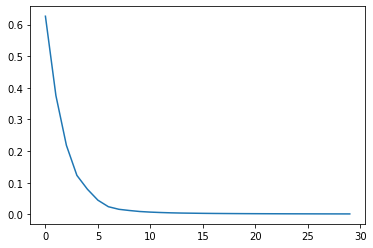

In [19]:
plt.plot(tr_loss_hist)